In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from ipywidgets import *

# Plot the figures inline and not in a pop-up
%matplotlib inline

In [2]:
class simulated_parameter:
    def __init__(self, parameter_name, parameter_mean, parameter_stddev):
        self._parameter_name = parameter_name
        self._parameter_mean = parameter_mean
        self._parameter_stddev = parameter_stddev

    def get_simulated_values(self, num_samples):
        return np.random.normal(
            loc=self._parameter_mean,
            scale=self._parameter_stddev,
            size=num_samples)

    def get_param_name(self):
        return self._parameter_name

In [3]:
def get_confidence_interval(values):
    num_simulations = len(values)
    # Find the median, 1, and 2 std dev values.
    probs = [0.045, 0.317, 0.5, 0.683, 0.955]
    indices = [int(prob * float(num_simulations)) for prob in probs]
    lower_2s = []
    lower_1s = []
    median = []
    upper_1s = []
    upper_2s = []
    for year in range(len(values[0])):
        yearly_values = [values[sim][year] for sim in range(num_simulations)]
        yearly_values.sort()
        lower_2s.append(yearly_values[indices[0]])
        lower_1s.append(yearly_values[indices[1]])
        median.append(yearly_values[indices[2]])
        upper_1s.append(yearly_values[indices[3]])
        upper_2s.append(yearly_values[indices[4]])
    return lower_2s, lower_1s, median, upper_1s, upper_2s

In [4]:
def simulate_portfolio(initial_value,
                       initial_contribution,
                       annual_earnings_increase,
                       annual_rate_of_return,
                       num_years,
                       num_simulations):
    values = []
    incomes = []

    # Loop over the number of years.
    for _ in range(num_simulations):
        curr_values = [initial_value]
        curr_incomes = [initial_contribution]
        for y in range(num_years):
            increase = annual_earnings_increase.get_simulated_values(1)
            ror = annual_rate_of_return.get_simulated_values(1)
            new_income = curr_incomes[-1] * increase[0]
            new_value = curr_values[-1] * ror[0]
            curr_incomes.append(new_income)
            curr_values.append(new_value + new_income)
        values.append(curr_values)
        incomes.append(curr_incomes)
            
    return values, incomes

In [5]:
def get_crossing_dates(values, years, threshold):
    results = []
    for v in values:
        for y in range(len(years)):
            if v[y] > threshold:
                results.append(years[y])
                break
    return results

In [19]:
def plot_ci(x, ys, xlabel, ylabel, title):
    lower_2s, lower_1s, median, upper_1s, upper_2s = get_confidence_interval(ys)
    fig, ax = plt.subplots(figsize=(10,5))
    years = [2019 + i for i in range(num_years + 1)]
    ax.plot(x, median, label='median', color='r')
    ax.fill_between(years, lower_2s, upper_2s, facecolor='r', alpha=0.15)
    ax.fill_between(years, lower_1s, upper_1s, facecolor='r', alpha=0.35)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.grid()
    #plt.yscale('log')
    plt.show()

def plot_two_ci(x, ys1, ys2, xlabel, ylabel, title):
    lower_2s_1, lower_1s_1, median_1, upper_1s_1, upper_2s_1 = get_confidence_interval(ys1)
    lower_2s_2, lower_1s_2, median_2, upper_1s_2, upper_2s_2 = get_confidence_interval(ys2)
    fig, ax = plt.subplots(figsize=(10,5))
    years = [2019 + i for i in range(num_years + 1)]
    ax.plot(x, median_1, label='median', color='g')
    ax.fill_between(years, lower_2s_1, upper_2s_1, facecolor='g', alpha=0.15)
    ax.fill_between(years, lower_1s_1, upper_1s_1, facecolor='g', alpha=0.35)
    ax.plot(x, median_2, label='median no investment', color='b')
    ax.fill_between(years, lower_2s_2, upper_2s_2, facecolor='b', alpha=0.15)
    ax.fill_between(years, lower_1s_2, upper_1s_2, facecolor='b', alpha=0.35)
    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)
    ax.grid()
    #plt.yscale('log')
    plt.show()

In [26]:
def graph_update(earnings_increase,
                 earnings_increase_stddev,
                 rate_of_return,
                 rate_of_return_stddev,
                 threshold):

    annual_earnings_increase = simulated_parameter(
        'annual_earnings_increase',
        earnings_increase,
        earnings_increase_stddev)
    annual_rate_of_return = simulated_parameter(
        'annual_rate_of_return',
        rate_of_return,
        rate_of_return_stddev)
    annual_rate_of_return_ni = simulated_parameter(
        'annual_rate_of_return',
        1.0,
        0.01)

    values, incomes = simulate_portfolio(
        initial_value,
        initial_contribution,
        annual_earnings_increase,
        annual_rate_of_return,
        num_years,
        num_simulations)

    values_ni, incomes_ni = simulate_portfolio(
        initial_value,
        initial_contribution,
        annual_earnings_increase,
        annual_rate_of_return_ni,
        num_years,
        num_simulations)

    years = [2019 + i for i in range(num_years + 1)]
    
    # Plot of the expected annual income per year.
    plot_ci(years, incomes, 'Year', 'Income [$M]', 'Income')
    
    # Plot of the expected portfolio value by year.
    plot_two_ci(years, values, values_ni, 'Year', 'Value [$M]', 'Portfolio Value')
    
    # Plot the expected dates for reaching a certain portfolio value.
    dates = get_crossing_dates(values, years, threshold)
    dates.sort()
    nbins = dates[len(dates) - 1] - dates[0]

    dates_ni = get_crossing_dates(values_ni, years, threshold)
    dates_ni.sort()
    nbins_ni = dates_ni[len(dates_ni) - 1] - dates_ni[0]

    fig, ax = plt.subplots(1, 1)
    ax.hist(dates, bins=nbins, histtype='bar', facecolor='g', alpha=0.2)
    ax.hist(dates_ni, bins=nbins_ni, histtype='bar', facecolor='b', alpha=0.4)
    

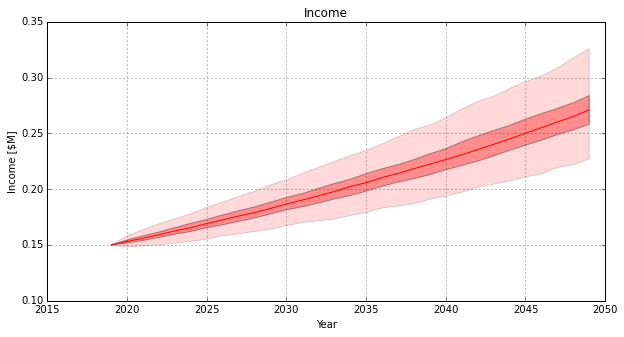

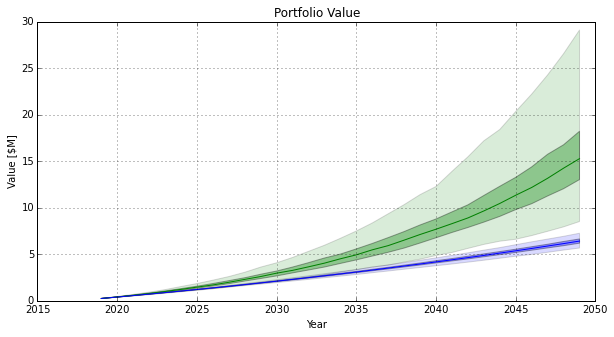

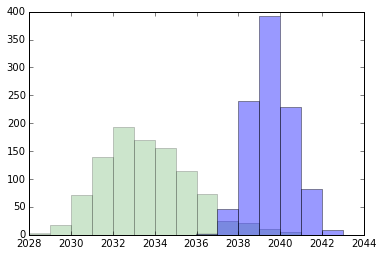

In [27]:
initial_value = 0.25
initial_contribution = 0.15
num_years = 30
num_simulations = 1000

interact(graph_update,
         earnings_increase=widgets.FloatSlider(value=1.02,
                                       min=0.8,
                                       max=1.2,
                                       step=0.02),
         earnings_increase_stddev=widgets.FloatSlider(value=0.02,
                                       min=0.000001,
                                       max=0.1,
                                       step=0.01),
         rate_of_return=widgets.FloatSlider(value=1.06,
                                       min=0.8,
                                       max=1.2,
                                       step=0.01),
         rate_of_return_stddev=widgets.FloatSlider(value=0.15,
                                       min=0.000001,
                                       max=0.2,
                                       step=0.01),
         threshold=widgets.FloatSlider(value=5,
                                       min=initial_value + 0.1,
                                       max=50*initial_value,
                                       step=0.1))